In [36]:
import pandas as pd
import numpy as np
from utils import load_series_dfs
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from scipy.signal import periodogram
import logging

In [2]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johan\Documents\FH_Master\data", filename="energy_with_weather.pkl")
series_dfs['FL_00024702.PLAN.MengeHH'].columns

Index(['consumption', 'hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
       'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10',
       'w_tb20'],
      dtype='object')

In [3]:
start, end = series_dfs['FL_00024702.PLAN.MengeHH'].index.min(), series_dfs['FL_00024702.PLAN.MengeHH'].index.max()
start, end

(Timestamp('2014-01-01 06:00:00'), Timestamp('2018-12-31 23:00:00'))

In [5]:
df = series_dfs['FL_00024702.PLAN.MengeHH']
# 1. Stationaritätstest (ADF-Test)
adf_result = adfuller(df['consumption'].dropna())
print(f'ADF-Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, val in adf_result[4].items():
    print(f'   {key}: {val:.4f}')

ADF-Statistic: -4.2186
p-value: 0.0006
Critical Values:
   1%: -3.4305
   5%: -2.8616
   10%: -2.5668


In [13]:
series_dfs['FL_00024702.PLAN.MengeHH']['consumption']

von  | von
2014-01-01 06:00:00     1.472
2014-01-01 07:00:00     1.517
2014-01-01 08:00:00     1.472
2014-01-01 09:00:00     1.517
2014-01-01 10:00:00     1.495
                        ...  
2018-12-31 19:00:00    32.223
2018-12-31 20:00:00    29.348
2018-12-31 21:00:00    24.727
2018-12-31 22:00:00    17.483
2018-12-31 23:00:00    15.874
Name: consumption, Length: 43888, dtype: float64

In [14]:
# Funktion für den ADF-Test
def adf_test(ts):
    """Führt den ADF-Test durch und liefert eine dict mit den Ergebnissen."""
    result = adfuller(ts.dropna())
    return {
        'adf_statistic': result[0],
        'p_value': result[1],
        'crit_1%': result[4]['1%'],
        'crit_5%': result[4]['5%'],
        'crit_10%': result[4]['10%']
    }

# Schleife über alle Serien im Dictionary
results = []
for name, series in series_dfs.items():
    res = adf_test(series_dfs[name]['consumption'])
    res['series_key'] = name
    results.append(res)

# Ergebnisse in DataFrame umwandeln
results_df = pd.DataFrame(results).set_index('series_key')

# Stationaritätsentscheidung hinzufügen
results_df['stationary (p < 0.05)'] = results_df['p_value'] < 0.05

# Ergebnisse anzeigen
results_df

,adf_statistic,p_value,crit_1%,crit_5%,crit_10%,stationary (p < 0.05)
series_key,,,,,,
FL_00024702.PLAN.MengeHH,-4.218636,6.126398e-04,-3.430499,-2.861606,-2.566805,True
FL_00024730.PLAN.MengeHH,-15.716448,1.340040e-28,-3.430499,-2.861606,-2.566805,True
FL_00352243.PLAN.MengeHH,-8.346508,3.075139e-13,-3.430499,-2.861606,-2.566805,True
FL_00352244.PLAN.MengeGA,-6.933516,1.069041e-09,-3.430499,-2.861606,-2.566805,True
FL_00352244.PLAN.MengeKW,-7.804570,7.339902e-12,-3.430499,-2.861606,-2.566805,True
FL_00024360.PLAN.MengeGA,-18.476959,2.135916e-30,-3.430499,-2.861606,-2.566805,True
FL_00352254.PLAN.MengeGA,-14.022628,3.548939e-26,-3.430499,-2.861606,-2.566805,True
FL_00025248.PLAN.MengeGA,-12.406073,4.449612e-23,-3.430499,-2.861606,-2.566805,True
FL_00024360.PLAN.MengeHH.2,-7.970361,2.791927e-12,-3.430499,-2.861606,-2.566805,True


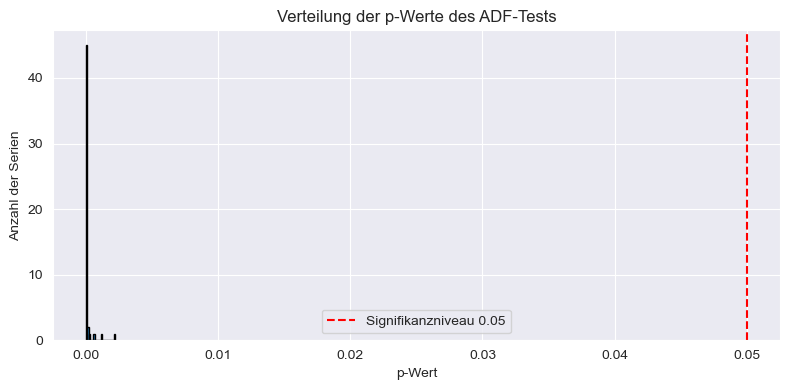

In [16]:
# Histogramm der p-Werte
plt.figure(figsize=(8, 4))
plt.hist(results_df['p_value'], bins=20, edgecolor='black')
plt.axvline(0.05, color='r', linestyle='--', label='Signifikanzniveau 0.05')
plt.title('Verteilung der p-Werte des ADF-Tests')
plt.xlabel('p-Wert')
plt.ylabel('Anzahl der Serien')
plt.legend()
plt.tight_layout()
plt.show()

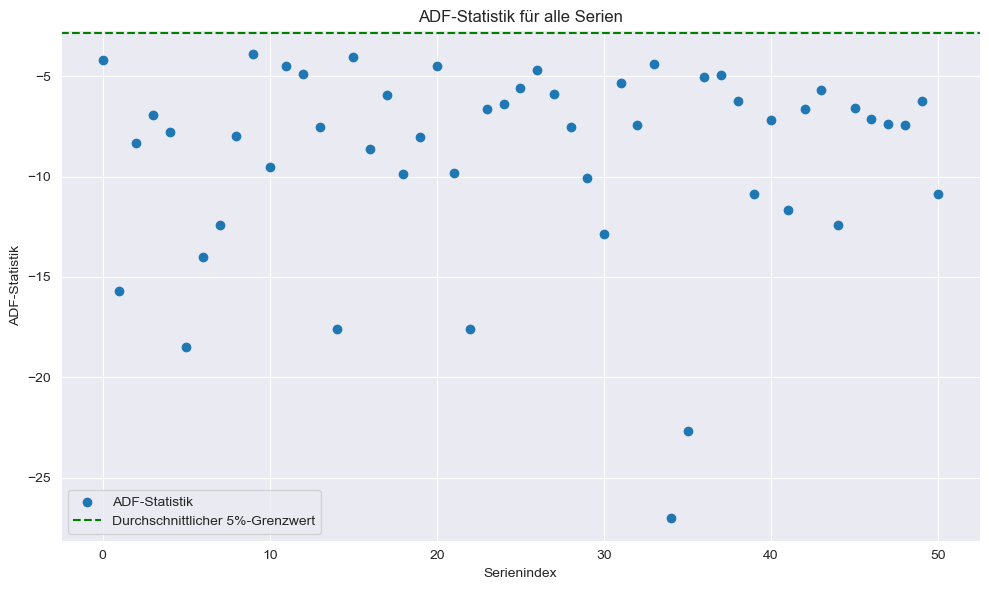

In [17]:
# Scatter-Plot der ADF-Statistik
plt.figure(figsize=(10, 6))
indices = range(len(results_df))
plt.scatter(indices, results_df['adf_statistic'], label='ADF-Statistik')
mean_crit5 = results_df['crit_5%'].mean()
plt.axhline(mean_crit5, color='g', linestyle='--', label='Durchschnittlicher 5%-Grenzwert')
plt.title('ADF-Statistik für alle Serien')
plt.xlabel('Serienindex')
plt.ylabel('ADF-Statistik')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
example_key = list(series_dfs.keys())[0]
series = series_dfs[example_key]['consumption'].dropna()

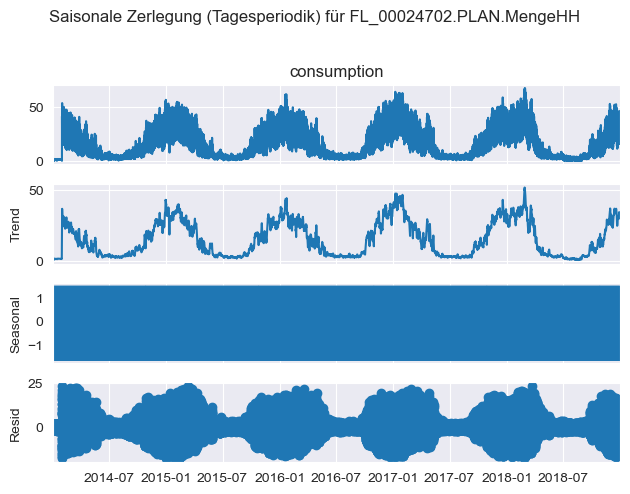

In [20]:
# 1) Additive Zerlegung (Tagesperiodik p=24)
decomp_daily = seasonal_decompose(series, model='additive', period=24)
fig1 = decomp_daily.plot()
fig1.suptitle(f"Saisonale Zerlegung (Tagesperiodik) für {example_key}", y=1.02)
plt.tight_layout()
plt.show()

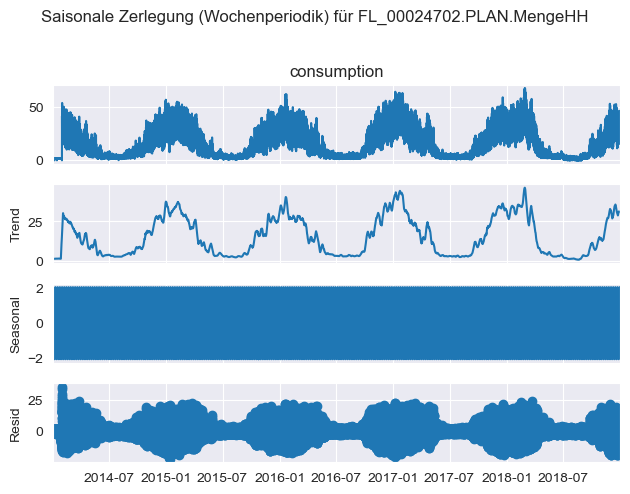

In [21]:
# 2) Additive Zerlegung (Wochenperiodik p=168)
decomp_weekly = seasonal_decompose(series, model='additive', period=24*7)
fig2 = decomp_weekly.plot()
fig2.suptitle(f"Saisonale Zerlegung (Wochenperiodik) für {example_key}", y=1.02)
plt.tight_layout()
plt.show()

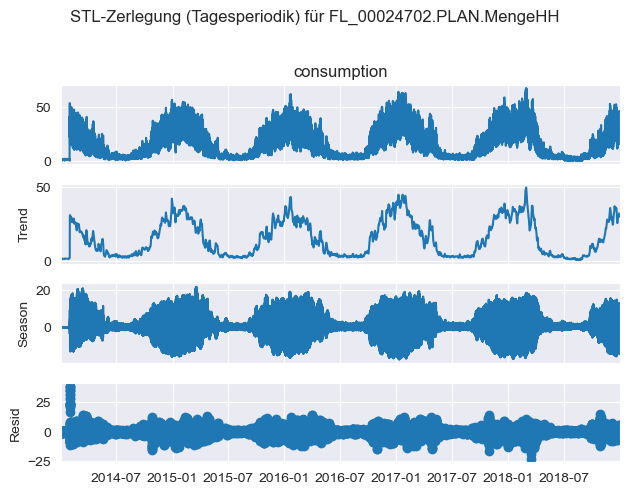

In [22]:
# 3) STL-Zerlegung (robust gegenüber Ausreißern, Tagesperiodik)
stl = STL(series, period=24, robust=True)
res_stl = stl.fit()
fig3 = res_stl.plot()
fig3.suptitle(f"STL-Zerlegung (Tagesperiodik) für {example_key}", y=1.02)
plt.tight_layout()
plt.show()

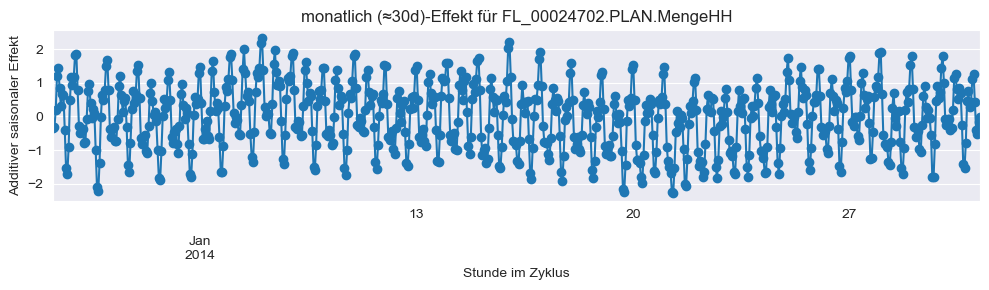

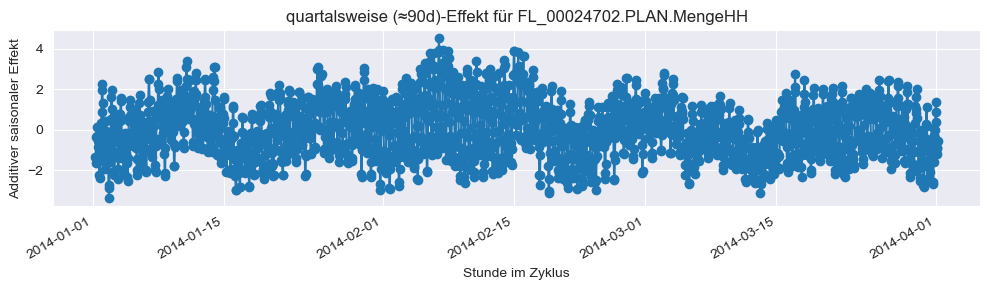

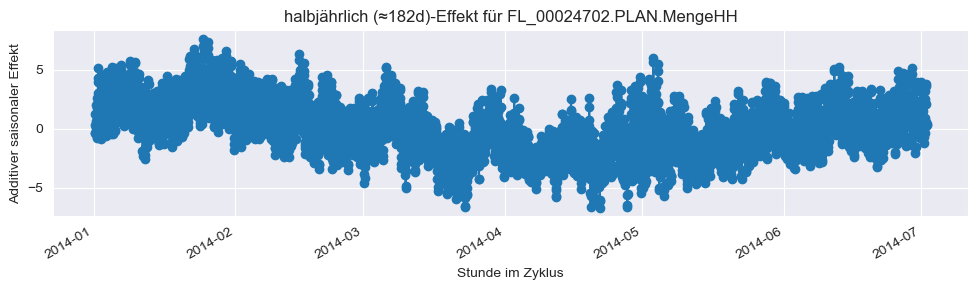

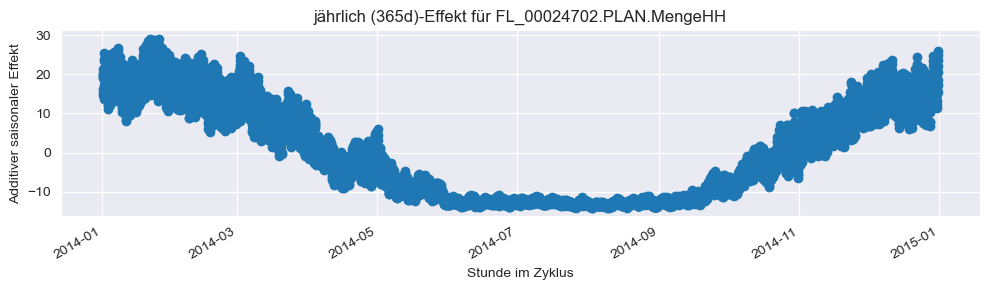

In [23]:
series = series_dfs[example_key]['consumption'].dropna()

periods = {
    'monatlich (≈30d)': 30*24,
    'quartalsweise (≈90d)': 90*24,
    'halbjährlich (≈182d)': 182*24,
    'jährlich (365d)': 365*24
}

for name, p in periods.items():
    # wir brauchen mindestens 2–3 vollständige Zyklen, sonst verwirft decompose
    if len(series) < p*3:
        print(f"🔶 Zu wenig Daten für {name}: {len(series)} Punkte < 3×{p}")
        continue

    decomp = seasonal_decompose(series, model='additive', period=p)
    plt.figure(figsize=(10,3))
    decomp.seasonal.iloc[:p].plot(marker='o')
    plt.title(f"{name}-Effekt für {example_key}")
    plt.xlabel("Stunde im Zyklus")
    plt.ylabel("Additiver saisonaler Effekt")
    plt.tight_layout()
    plt.show()

Varianz der saisonalen Komponente:
  Period = 24 Stunden ➔ Varianz = 0.68
  Period = 168 Stunden ➔ Varianz = 0.86
  Period = 720 Stunden ➔ Varianz = 0.90
  Period = 2160 Stunden ➔ Varianz = 1.83
  Period = 8760 Stunden ➔ Varianz = 142.74

Gesamtvarianz der Serie: 180.39
  Anteil (p=24): 0.38%
  Anteil (p=168): 0.48%
  Anteil (p=720): 0.50%
  Anteil (p=2160): 1.01%
  Anteil (p=8760): 79.13%


C:\Users\johan\AppData\Local\Temp\ipykernel_1332\178298121.py:25: RuntimeWarning: divide by zero encountered in divide
  periods_hours = 1 / freqs


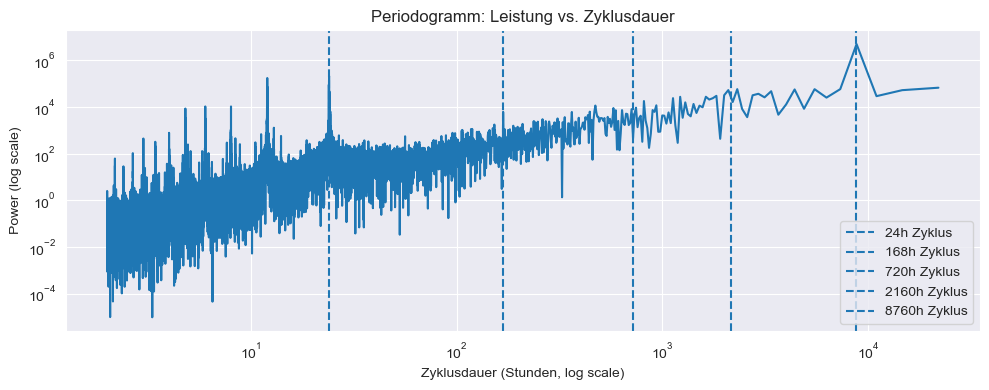

In [28]:
# Beispiel: Wähle eine Serie
example_key = list(series_dfs.keys())[0]
series = series_dfs[example_key]['consumption'].dropna()

# 1) Varianz der saisonalen Komponenten für verschiedene Perioden
periods = [24, 168,30*24,90*24, 365*24]
vars_season = {}
for p in periods:
    decomp = seasonal_decompose(series, model='additive', period=p)
    vars_season[p] = np.var(decomp.seasonal)

# Ausgabe der Varianzen
print("Varianz der saisonalen Komponente:")
for p, v in vars_season.items():
    print(f"  Period = {p} Stunden ➔ Varianz = {v:.2f}")

# 2) Relative Stärke: Anteil an Gesamtvarianz
total_var = np.var(series)
print(f"\nGesamtvarianz der Serie: {total_var:.2f}")
for p, v in vars_season.items():
    print(f"  Anteil (p={p}): {v/total_var:.2%}")

# 3) Periodogramm (PSD) zur Visualisierung dominanter Frequenzen
freqs, power = periodogram(series, fs=1)  # fs=1 sample/Stunde
periods_hours = 1 / freqs
# Filter sinnvolle Frequenzen (z.B. Perioden zwischen 2h und 40000h)
mask = (periods_hours >= 2) & (periods_hours <= 40000)

plt.figure(figsize=(10,4))
plt.plot(periods_hours[mask], power[mask])
plt.xscale('log')
plt.yscale('log')
for p in periods:
    plt.axvline(p, linestyle='--', label=f'{p}h Zyklus')
plt.title('Periodogramm: Leistung vs. Zyklusdauer')
plt.xlabel('Zyklusdauer (Stunden, log scale)')
plt.ylabel('Power (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\johan\AppData\Local\Temp\ipykernel_1332\3901002789.py:7: RuntimeWarning: divide by zero encountered in divide
  periods_hours = 1 / freqs


,power_24h,power_168h,power_720h,power_2160h,power_8760h
series_key,,,,,
FL_00024702.PLAN.MengeHH,6.895527e+03,6.190564e+03,4.512390e+02,1.642866e+04,5.024282e+06
FL_00024730.PLAN.MengeHH,3.804886e+03,6.982785e+05,1.707649e+03,5.504713e+03,1.518819e+06
FL_00352243.PLAN.MengeHH,7.782368e+03,3.963173e+05,1.728226e+02,3.684859e+03,5.143671e+06
FL_00352244.PLAN.MengeGA,4.142043e+04,5.711399e+06,2.923793e+06,3.092278e+07,2.606367e+08
FL_00352244.PLAN.MengeKW,2.666769e+06,3.288456e+07,6.388354e+05,6.634955e+06,1.005040e+09
FL_00024360.PLAN.MengeGA,7.815114e+13,6.836437e+15,9.194607e+15,9.622280e+15,9.968000e+15
FL_00352254.PLAN.MengeGA,1.097748e+03,6.481724e+03,3.881742e+04,2.076850e+05,1.183152e+06
FL_00025248.PLAN.MengeGA,1.019806e+03,7.830933e+04,1.164937e+04,3.016459e+03,4.711066e+05
FL_00024360.PLAN.MengeHH.2,6.628207e+01,2.366696e+03,1.509645e+04,8.413369e+04,1.320083e+05


C:\Users\johan\AppData\Local\Temp\ipykernel_1332\3901002789.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


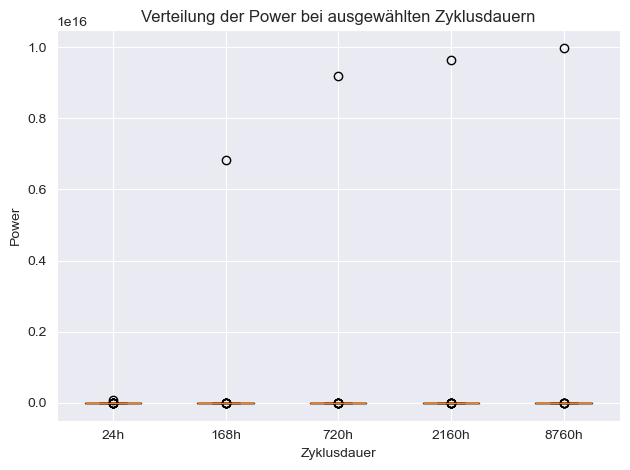

In [30]:
periods = [24, 168,30*24,90*24, 8760]
summary = []

for name, series in series_dfs.items():
    s = series_dfs[name]['consumption']
    freqs, power = periodogram(s, fs=1)
    periods_hours = 1 / freqs

    entry = {'series_key': name}
    for p in periods:
        # nächstgelegene Frequenz für Periode p finden
        idx = np.abs(periods_hours - p).argmin()
        entry[f'power_{p}h'] = power[idx]
    summary.append(entry)

# DataFrame mit den Power-Werten
summary_df = pd.DataFrame(summary).set_index('series_key')

# 1) Übersichtstabelle anzeigen
import IPython.display as disp
disp.display(summary_df)


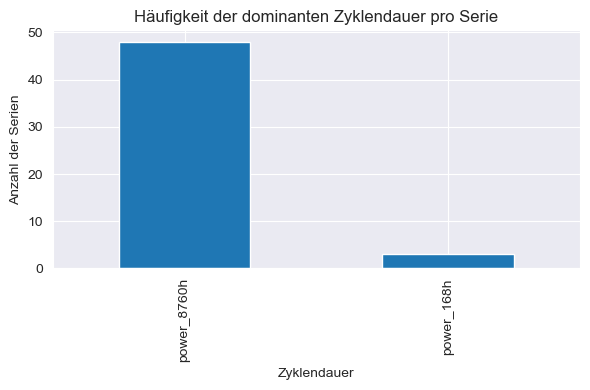

In [32]:
# 1) Relativen Beitrag jeder Perioden-Power pro Serie berechnen
rel_df = summary_df.div(summary_df.sum(axis=1), axis=0) * 100

# 2) Welcher Zyklus hat für jede Serie den höchsten Power-Anteil?
dominant = rel_df.idxmax(axis=1).value_counts()

# 3) Visualisierung: Balkendiagramm der dominanten Perioden
plt.figure(figsize=(6,4))
dominant.plot(kind='bar')
plt.title('Häufigkeit der dominanten Zyklendauer pro Serie')
plt.ylabel('Anzahl der Serien')
plt.xlabel('Zyklendauer')
plt.tight_layout()
plt.show()



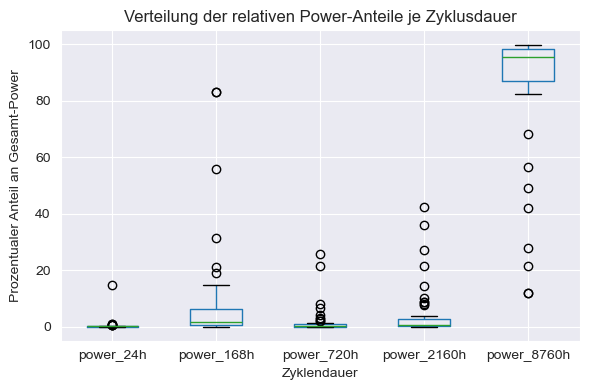

In [34]:
# 4) Boxplot der relativen Beiträge für alle Perioden
plt.figure(figsize=(6,4))
rel_df.boxplot()
plt.title('Verteilung der relativen Power-Anteile je Zyklusdauer')
plt.ylabel('Prozentualer Anteil an Gesamt-Power')
plt.xlabel('Zyklendauer')
plt.tight_layout()
plt.show()


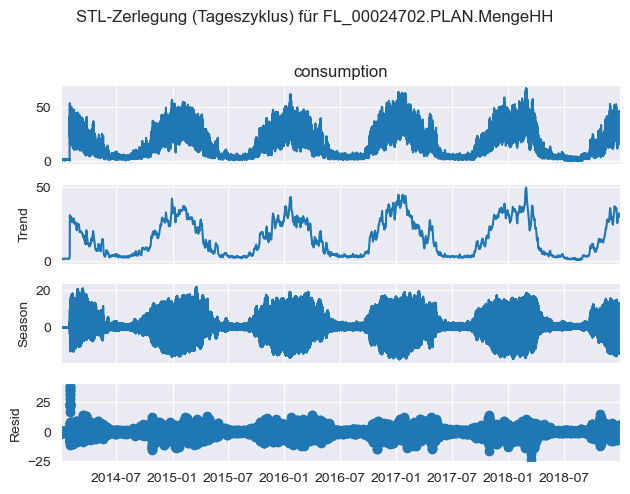

In [35]:
series = series_dfs[example_key]['consumption'].dropna()

# Einfache STL mit Tagesperiodik
stl = STL(series, period=24, robust=True)
res = stl.fit()

fig = res.plot()
fig.suptitle(f"STL-Zerlegung (Tageszyklus) für {example_key}", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Verwende dieselbe Beispiel-Serie
mstl = MSTL(series, periods=[24, 168, 365*24])
res_mstl = mstl.fit()

fig = res_mstl.plot()
fig.suptitle(f"MSTL-Zerlegung für {example_key}", y=1.02)
plt.tight_layout()
plt.show()